### All imports

In [1]:
!python3 -m pip install imagehash Image

In [2]:
import imagehash
from PIL import Image
import numpy as np
import torch 
import torchvision
from matplotlib import pyplot as plt

In [17]:
torch.set_default_device('cuda:0') 
device = torch.device('cuda:0')

### Hash functions

In [18]:
def phash(image_file: str, hash_size: int = 8) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.phash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

def dhash(image_file: str, hash_size: int = 8) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

def ahash(image_file: str, hash_size: int = 8) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.average_hash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

def whash(image_file: str, hash_size: int = 8) -> np.ndarray:
    pil_image = Image.open(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.whash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

### Own Hash Function

In [195]:
def convolve(img, weights, hash_size, padding_size = 0):
    tensor_image = torch.reshape(img,(1,1,hash_size, hash_size)).to(device)
    conv_img = torch.nn.functional.conv2d(tensor_image, weights, padding=int(padding_size))
    conv_img = conv_img.squeeze(0)
    conv_img = torch.permute(conv_img, (1,2,0))
    return conv_img

def gauss_kernel(size, sig=1.):
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    res = kernel / np.sum(kernel)
    return torch.DoubleTensor(res.reshape(1,1,size,size)).to(device)

def sobel_filters(img):
    
    Kx = torch.DoubleTensor([[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]).to(device)
    Ky = torch.DoubleTensor([[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]]).to(device)
    
    img = img.unsqueeze(0).to(device)
    img = torch.permute(img, (0,3,1,2))

    Ix = torch.nn.functional.conv2d(img, Kx.unsqueeze(0))
    Iy = torch.nn.functional.conv2d(img, Ky.unsqueeze(0))
    
    return Ix.cpu() , Iy.cpu()

def relu(grad, _min):
    return torch.where(grad > _min, grad, 0.)

def shash(image_file: str, hash_size: int, input_size = 100):
    pil_image = Image.open(image_file).resize(
                        (input_size, input_size),
                        Image.BILINEAR).convert("L")

    size = 5
    kernel = gauss_kernel(size)

    np_image = np.array(pil_image).astype(np.float64)
    tensor_image = torch.tensor(np_image).to(device)

    image_blurred = convolve(tensor_image, kernel, input_size, int(np.sqrt(size)))
    sobels = sobel_filters(image_blurred)
    
    gradient = np.sqrt(sobels[0]**2 + sobels[1]**2) 

    grad = relu(gradient, 0.5)
    grad = grad.squeeze(0)
    
    pil_image = torchvision.transforms.functional.to_pil_image(grad.to(torch.int32))
    pil_image.resize((hash_size+1, hash_size),Image.BILINEAR)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()

    return signature, grad.T
    #return grad

### AI Hash Function

In [196]:
MODEL_PATH = "../2.NeuralHashing/mainModel.pth"

In [197]:
from torchvision import models
import torch.nn as nn

resnet50 = models.resnet50(pretrained = True) # weights=ResNet50_Weights.DEFAULT
resnet50.fc = torch.nn.Identity()

In [198]:
class Net2(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.hash1 = nn.Linear(256, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = x.to(torch.float32)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

In [199]:
net2 = Net2( 64 )
model = nn.Sequential(resnet50, net2)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [200]:
for param in resnet50.parameters():
    param.requires_grad = False

model = model.eval()

### Hamming Distance

In [201]:
def distance(hashA, hashB, hash_size=8):
    hd = sum(np.bitwise_xor(hashA, hashB))
    similarity = (hash_size**2 - hd) / hash_size**2
    return similarity

### Data

In [202]:
imageList = ["1.Data/cat1.jpg", "1.Data/cat2.jpg", "1.Data/cat3.jpg", "1.Data/cat4.jpg"]

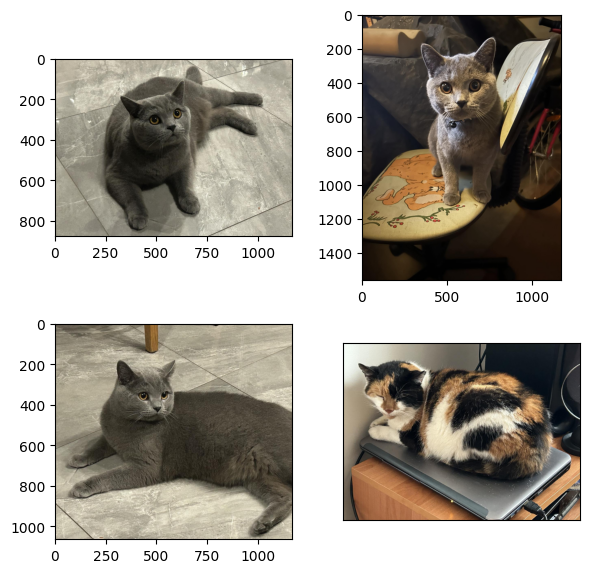

In [203]:
num_row = 2
num_col = 2

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 4):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.open(imageList[0], 'r'))

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(Image.open(imageList[1], 'r'))

    ax = axes[(i+2)//num_col, (i+2)%num_col]
    ax.imshow(Image.open(imageList[2], 'r'))
    
    ax = axes[(i+3)//num_col, (i+3)%num_col]
    ax.imshow(Image.open(imageList[3], 'r'))


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

### Helper Functions

In [220]:
def dHash2(img1, img2, hashSize = 8):
    hashA = dhash(img1, hashSize)
    hashB = dhash(img2, hashSize)
    return distance(hashA, hashB, hashSize)

def pHash2(img1, img2, hashSize = 8):
    hashA = phash(img1, hashSize)
    hashB = phash(img2, hashSize)
    return distance(hashA, hashB, hashSize)

def sHash2(img1, img2, hashSize = 16):
    hashA, gradA = shash(img1, hashSize)
    hashB, gradB = shash(img2, hashSize)
    return distance(hashA, hashB, hashSize), gradA, gradB

def nHash2(img1, img2, hashSize = 8):
    labelA, hashA = model(img1)
    labelB, hashB = model(img2)

    hashA = torch.round(hashA).to(torch.int).cpu().detach().numpy().flatten()
    hashB = torch.round(hashB).to(torch.int).cpu().detach().numpy().flatten()
    return distance(hashA, hashB, hashSize), (torch.max(labelA.data, 1)[1].item()), (torch.max(labelB.data, 1)[1].item())

### Experiments

(876, 1170, 3)
phash: 0.5	 dhash: 0.609375	 shash: 0.5546875	 nhash: 0.984375


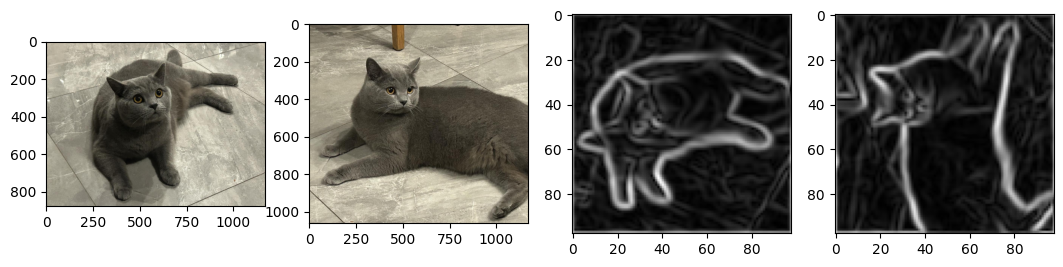

In [281]:
im0 = "1.Data/cat1.jpg"
im1 = "1.Data/cat3.jpg"

pImage0 = Image.open(im0, 'r')
pImage1 = Image.open(im1, 'r')

npImage0 = np.array(pImage0)
npImage1 = np.array(pImage1)

print(npImage0.shape)

tImage0 = torch.Tensor(np.resize(npImage0, (32,32,3)).reshape(1,3,32,32)).to(device)
tImage1 = torch.Tensor(np.resize(npImage1, (32,32,3)).reshape(1,3,32,32)).to(device)

fig, axes = plt.subplots(1, 4, figsize=(13,3))
ax = axes[0]
ax.imshow(pImage0)

ax = axes[1]
ax.imshow(pImage1)

val, grad1, grad2, = sHash2(im0, im1, 16) 
valNN, label1, label2, = nHash2(tImage0, tImage1)

ax = axes[2]
ax.imshow(grad1, cmap="gray")

ax = axes[3]
ax.imshow(grad2, cmap="gray")

print("phash: " + str(pHash2(im0, im1)) + "\t dhash: " + str(dHash2(im0, im1)) \
           + "\t shash: " + str(val) + "\t nhash: " + str(valNN) )
plt.show()

### One image rotated

In [282]:
image1 = Image.open(imageList[0])

In [283]:
image2 = image1.rotate(45)

In [284]:
pathA = "1.Data/cat1.jpg"
pathB = "1.Data/cat1Rotate.jpg"
image2.save("1.Data/cat1Rotate.jpg")

(876, 1170, 3)
phash: 0.5	 dhash: 0.609375	 shash: 0.5078125	 nhash: 0.9375


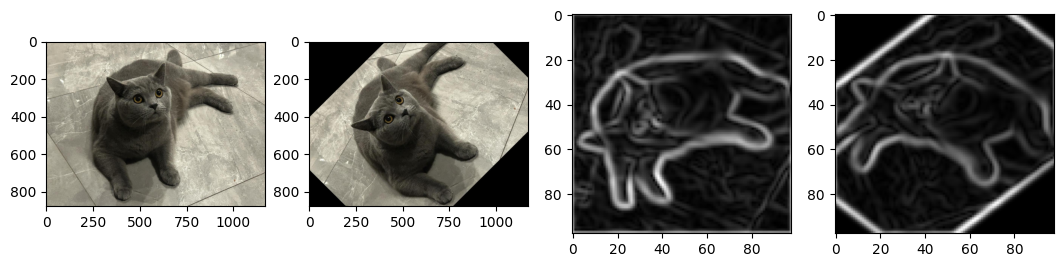

In [285]:
pImage0 = Image.open(pathA, 'r')
pImage1 = Image.open(pathB, 'r')

npImage0 = np.array(pImage0)
npImage1 = np.array(pImage1)

print(npImage0.shape)

tImage0 = torch.Tensor(np.resize(npImage0, (32,32,3)).reshape(1,3,32,32)).to(device)
tImage1 = torch.Tensor(np.resize(npImage1, (32,32,3)).reshape(1,3,32,32)).to(device)

fig, axes = plt.subplots(1, 4, figsize=(13,3))
ax = axes[0]
ax.imshow(pImage0)

ax = axes[1]
ax.imshow(pImage1)

val, grad1, grad2, = sHash2(pathA, pathB, 16) 
valNN, label1, label2, = nHash2(tImage0, tImage1)

ax = axes[2]
ax.imshow(grad1, cmap="gray")

ax = axes[3]
ax.imshow(grad2, cmap="gray")

print("phash: " + str(pHash2(im0, im1)) + "\t dhash: " + str(dHash2(im0, im1)) \
           + "\t shash: " + str(val) + "\t nhash: " + str(valNN) )
plt.show()

In [286]:
image2 = image1.rotate(-45)

In [287]:
pathA = "1.Data/cat1.jpg"
pathB = "1.Data/cat1Rotate2.jpg"
image2.save("1.Data/cat1Rotate2.jpg")

(876, 1170, 3)
phash: 0.5	 dhash: 0.609375	 shash: 0.53125	 nhash: 0.90625


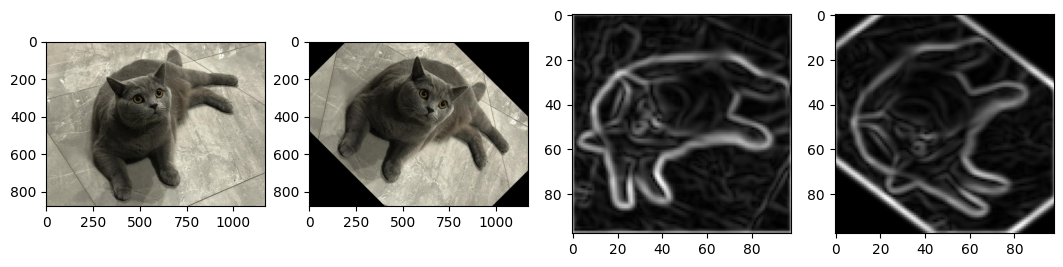

In [288]:
pImage0 = Image.open(pathA, 'r')
pImage1 = Image.open(pathB, 'r')

npImage0 = np.array(pImage0)
npImage1 = np.array(pImage1)

print(npImage0.shape)

tImage0 = torch.Tensor(np.resize(npImage0, (32,32,3)).reshape(1,3,32,32)).to(device)
tImage1 = torch.Tensor(np.resize(npImage1, (32,32,3)).reshape(1,3,32,32)).to(device)

fig, axes = plt.subplots(1, 4, figsize=(13,3))
ax = axes[0]
ax.imshow(pImage0)

ax = axes[1]
ax.imshow(pImage1)

val, grad1, grad2, = sHash2(pathA, pathB, 16) 
valNN, label1, label2, = nHash2(tImage0, tImage1)

ax = axes[2]
ax.imshow(grad1, cmap="gray")

ax = axes[3]
ax.imshow(grad2, cmap="gray")

print("phash: " + str(pHash2(im0, im1)) + "\t dhash: " + str(dHash2(im0, im1)) \
           + "\t shash: " + str(val) + "\t nhash: " + str(valNN) )
plt.show()

### Image cropped

In [289]:
image1 = Image.open(imageList[0])

In [290]:
width, height = image1.size
image2 = image1.crop((250, 200, 800, 800))

In [291]:
pathA = "1.Data/cat1.jpg"
pathB = "1.Data/cat1Cropped.jpg"
image2.save(pathB)

(876, 1170, 3)
phash: 0.5	 dhash: 0.609375	 shash: 0.5078125	 nhash: 1.0


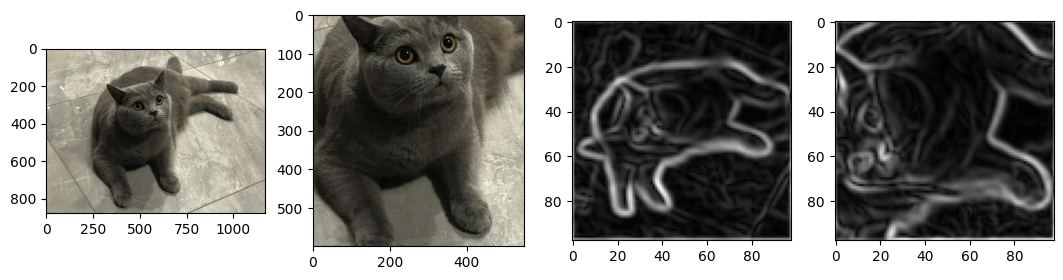

In [292]:
pImage0 = Image.open(pathA, 'r')
pImage1 = Image.open(pathB, 'r')

npImage0 = np.array(pImage0)
npImage1 = np.array(pImage1)

print(npImage0.shape)

tImage0 = torch.Tensor(np.resize(npImage0, (32,32,3)).reshape(1,3,32,32)).to(device)
tImage1 = torch.Tensor(np.resize(npImage1, (32,32,3)).reshape(1,3,32,32)).to(device)

fig, axes = plt.subplots(1, 4, figsize=(13,3))
ax = axes[0]
ax.imshow(pImage0)

ax = axes[1]
ax.imshow(pImage1)

val, grad1, grad2, = sHash2(pathA, pathB, 16) 
valNN, label1, label2, = nHash2(tImage0, tImage1)

ax = axes[2]
ax.imshow(grad1, cmap="gray")

ax = axes[3]
ax.imshow(grad2, cmap="gray")

print("phash: " + str(pHash2(im0, im1)) + "\t dhash: " + str(dHash2(im0, im1)) \
           + "\t shash: " + str(val) + "\t nhash: " + str(valNN) )
plt.show()

In [293]:
#!pip install -U scikit-image

In [294]:
from skimage.metrics import mean_squared_error    
from skimage.metrics import structural_similarity as ssim

In [295]:
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])

	return err
print( mse(gradC.numpy(), gradD.numpy()) )

arrays1 = np.squeeze(gradC.numpy())
arrays2 = np.squeeze(gradD.numpy())
arrays1 *= (255.0/arrays1.max())
arrays2 *= (255.0/arrays2.max())
print(arrays1.min())
print( ssim(arrays1, arrays2, channel_axis=-1, data_range=255))

7243.40818533051
0.0
0.12787560792332


In [296]:
from math import log10, sqrt 

def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

print(PSNR(arrays1,arrays2))

13.599085549732655


### missing pixels

In [297]:
image1 = Image.open(imageList[0])

In [298]:
pix = np.array(image1)

In [299]:
pix.shape

(876, 1170, 3)

In [300]:
for i in range(pix.shape[0]):
    if i % 4 == 0:
        pix[i, :] = 255

for i in range(pix.shape[1]):
    if i % 4 == 0:
        pix[:, i] = 255

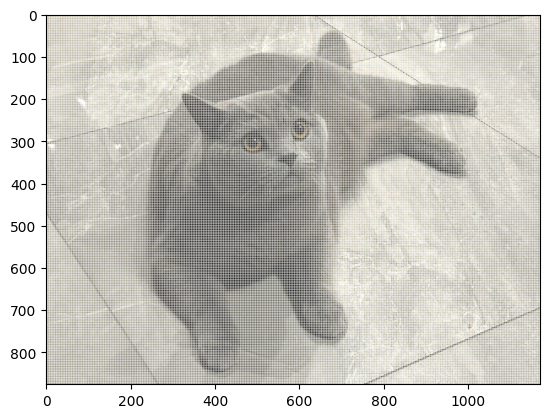

In [301]:
fig = plt.figure()
plt.imshow(pix)

In [302]:
pathA = "1.Data/cat1.jpg"
pathB = "1.Data/cat1Filter1.jpg"

im = Image.fromarray(np.uint8(pix))
im.save(pathB)

phash: 0.5	 dhash: 0.609375	 shash: 0.96484375	 nhash: 1.0


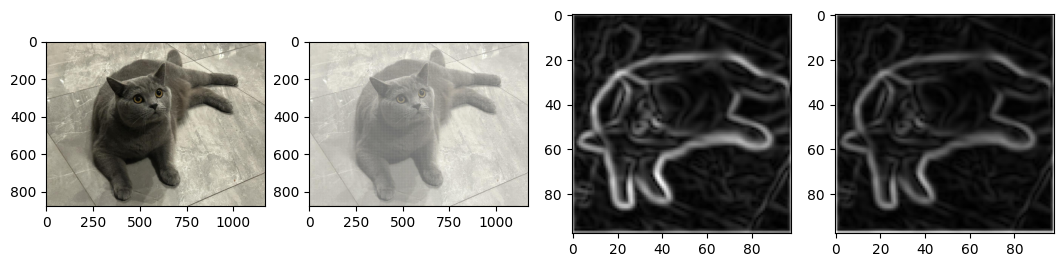

In [303]:
pImage0 = Image.open(pathA, 'r')
pImage1 = Image.open(pathB, 'r')

npImage0 = np.array(pImage0)
npImage1 = np.array(pImage1)

tImage0 = torch.Tensor(np.resize(npImage0, (32,32,3)).reshape(1,3,32,32)).to(device)
tImage1 = torch.Tensor(np.resize(npImage1, (32,32,3)).reshape(1,3,32,32)).to(device)

fig, axes = plt.subplots(1, 4, figsize=(13,3))
ax = axes[0]
ax.imshow(pImage0)

ax = axes[1]
ax.imshow(pImage1)

val, grad1, grad2, = sHash2(pathA, pathB, 16) 
valNN, label1, label2, = nHash2(tImage0, tImage1)

ax = axes[2]
ax.imshow(grad1, cmap="gray")

ax = axes[3]
ax.imshow(grad2, cmap="gray")

print("phash: " + str(pHash2(im0, im1)) + "\t dhash: " + str(dHash2(im0, im1)) \
           + "\t shash: " + str(val) + "\t nhash: " + str(valNN) )
plt.show()

### Not correlated picture

In [310]:
pathA = "1.Data/cat1.jpg"
pathB = "1.Data/dog1.png"

phash: 0.5	 dhash: 0.609375	 shash: 0.56640625	 nhash: 1.0


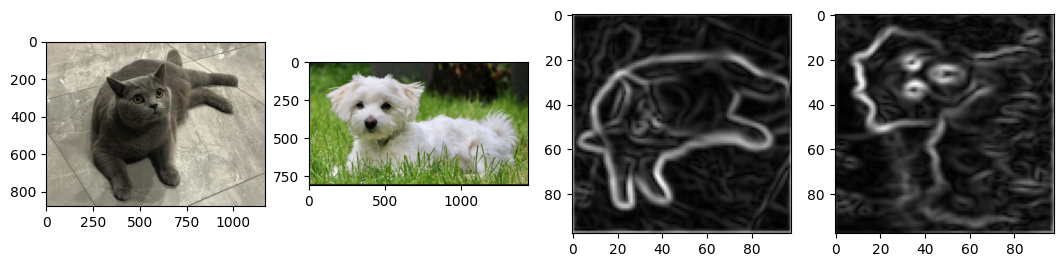

In [314]:
pImage0 = Image.open(pathA, 'r')
pImage1 = Image.open(pathB, 'r')

npImage0 = np.array(pImage0)
npImage1 = np.array(pImage1)

tImage0 = torch.Tensor(np.resize(npImage0, (32,32,3)).reshape(1,3,32,32)).to(device)
tImage1 = torch.Tensor(np.resize(npImage1, (32,32,3)).reshape(1,3,32,32)).to(device)

fig, axes = plt.subplots(1, 4, figsize=(13,3))
ax = axes[0]
ax.imshow(pImage0)

ax = axes[1]
ax.imshow(pImage1)

val, grad1, grad2, = sHash2(pathA, pathB, 16) 
valNN, label1, label2, = nHash2(tImage0, tImage1)

ax = axes[2]
ax.imshow(grad1, cmap="gray")

ax = axes[3]
ax.imshow(grad2, cmap="gray")

print("phash: " + str(pHash2(im0, im1)) + "\t dhash: " + str(dHash2(im0, im1)) \
           + "\t shash: " + str(val) + "\t nhash: " + str(valNN) )
plt.show()

### 2 zestaw (10 zdjęć ) i 2 model